<a href="https://colab.research.google.com/github/nfrn/ComputerVisionHandsOn/blob/main/Forma%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nfrn/ComputerVisionHandsOn.git
%cd /content/ComputerVisionHandsOn/
!unzip maskdataset.zip

Cloning into 'ComputerVisionHandsOn'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.
/content/ComputerVisionHandsOn
Archive:  maskdataset.zip
 extracting: test/w1240-p16x9-2019-10-04t075956z_1862636027_rc15d4d49d00_rtrmadp_3_hongkong-protests_jpg.rf.a9a2c2a1cb13c980b339065d2324ea7d.jpg  
 extracting: train/11893820-3x2-xlarge_jpg.rf.1529b09bfee7d069f677ff513f6249eb.jpg  
 extracting: train/130624011830-malaysia-smog-students-horizontal-large-gallery_jpg.rf.1d1478ec7b2667aa240401f636d513c4.jpg  
 extracting: test/126202-untitled-design-13_jpg.rf.baa3d2e55d469ae5d5d4cd81c4603e1d.jpg  
 extracting: test/r1p00017o8171pnq407_jpg.rf.d21dd91220d3df7763f7d572f3d95863.jpg  
 extracting: test/15391513329330sooq10859_jpg.rf.bf9e791012521a572a3a7f2979d0dffe.jpg  
 extracting: train/1125506397_15801322206131n_jp

In [2]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 20.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 12.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=313bade2504b98289dccbe7d8d2e1

In [10]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_maskdataset_train", {}, "/content/ComputerVisionHandsOn/train/_annotations.coco.json", "/content/ComputerVisionHandsOn/train")
register_coco_instances("my_maskdataset_val", {}, "/content/ComputerVisionHandsOn/_annotations.coco.json", "/content/ComputerVisionHandsOn/valid")
register_coco_instances("my_maskdataset_test", {}, "/content/ComputerVisionHandsOn/_annotations.coco.json", "/content/ComputerVisionHandsOn/test")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



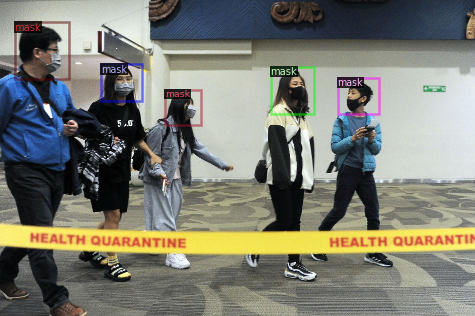

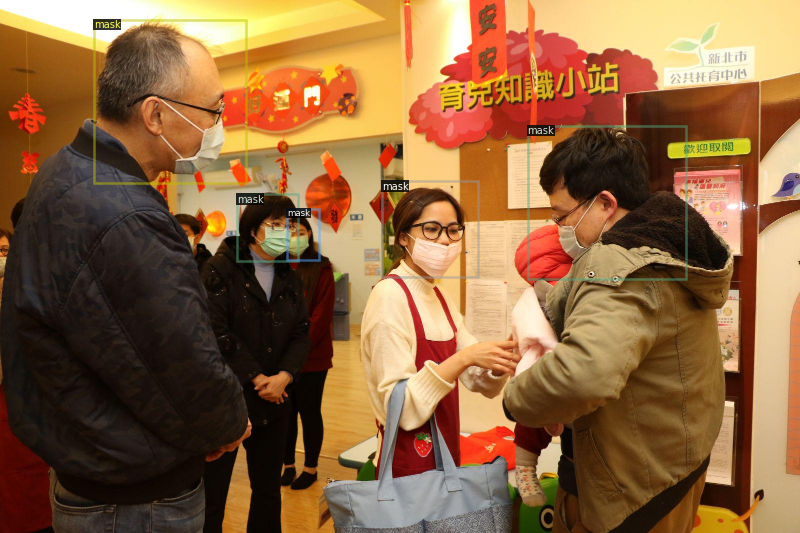

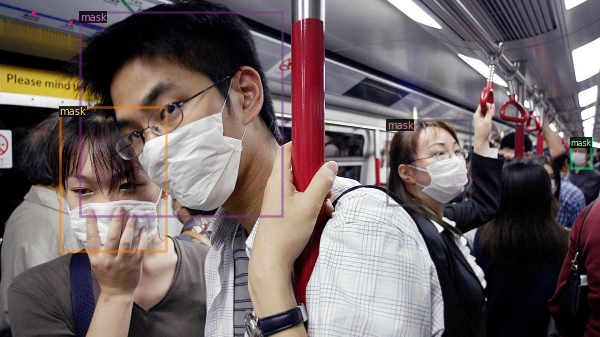

In [14]:
#visualize training data
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
from google.colab.patches import cv2_imshow

my_dataset_train_metadata = MetadataCatalog.get("my_maskdataset_train")
dataset_dicts = DatasetCatalog.get("my_maskdataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [15]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [18]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2 import model_zoo
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_maskdataset_train",)
cfg.DATASETS.TEST = ("my_maskdataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/20 15:48:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

coco_2017_train_box_proposals_21bc3a.pkl: 3.22GB [04:42, 11.4MB/s]                            


KeyError: ignored